In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [19]:
import sys
sys.path.append(r'C:\Users\HP\week 11 final\time_series_modeling\scripts')  

import data_loading

In [20]:
# Assuming you have the preprocessed data from data_loading.py
data = data_loading.load_stock_data("TSLA", "2015-01-01", "2024-10-31")
preprocessed_data = data_loading.preprocess_data(data)

# Extract closing prices for TSLA
tsla_close = preprocessed_data['Close']

[*********************100%***********************]  1 of 1 completed
C:\Users\HP\week 11 final\time_series_modeling\scripts\data_loading.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [21]:
# Train-test split 
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [22]:
preprocessed_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2015-01-02 00:00:00+00:00,14.620667,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05 00:00:00+00:00,14.006000,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06 00:00:00+00:00,14.085333,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07 00:00:00+00:00,14.063333,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08 00:00:00+00:00,14.041333,14.041333,14.253333,14.000667,14.187333,51637500


In [23]:
# Load data (assuming you have a CSV file with 'Date' and 'Adj Close' columns)
data = preprocessed_data

In [24]:
# Prepare data for LSTM
def create_dataset(dataset, look_back=60):
  X, y = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    X.append(a)
    y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(y)


In [25]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Adj Close'].values.reshape(-1, 1))

In [26]:
# Split into training and testing sets
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [27]:
# Reshape input to be [samples, time steps, features]
look_back = 60
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

In [28]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [29]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\HP\11 final\time_series_modeling\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # Monitor validation loss


In [31]:
# Train the model with Early Stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0368 - val_loss: 0.0022
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.6230e-04 - val_loss: 0.0020
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 8.9422e-04 - val_loss: 0.0014
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.2659e-04 - val_loss: 0.0013
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 6.8730e-04 - val_loss: 0.0013
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 6.4062e-04 - val_loss: 0.0012
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 6.7661e-04 - val_loss: 0.0011
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 5.1948e-04 - val_loss: 0.0011
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 5.9165e-04 - val_loss: 0.0018


In [32]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [33]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print('LSTM Model:')
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)

LSTM Model:
Mean Squared Error: 52132.27250319022
Root Mean Squared Error: 228.32492746783086
Mean Absolute Error: 225.77103429275047
Mean Absolute Percentage Error: 442.40579599521783


In [40]:
# Prepare future data for forecasting
future_data = test[-look_back:]  # Use the last 'look_back' values from the test set
future_data = future_data.reshape((1, look_back, 1))

In [41]:
# Make predictions for the future
future_predictions = model.predict(future_data)
future_predictions = scaler.inverse_transform(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [42]:
# Assuming 'data' has a Datetime index
last_train_date = data.index[train_size - 1]
forecast_dates = [last_train_date + pd.DateOffset(days=i) for i in range(len(future_predictions))]

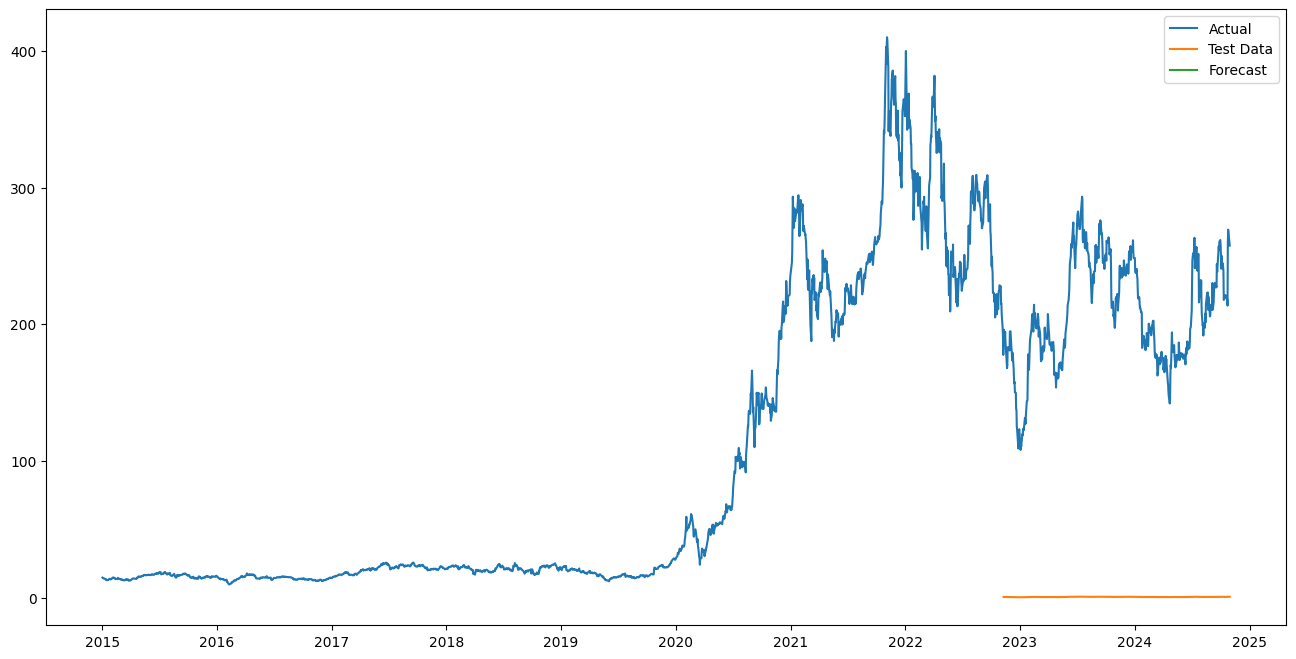

In [43]:
# Visualize the results
plt.figure(figsize=(16, 8))
plt.plot(data['Adj Close'], label='Actual')
plt.plot(data[train_size:].index, test, label='Test Data')
plt.plot(forecast_dates, future_predictions, label='Forecast')
plt.legend()
plt.show()

In [ ]:
# Define seasonal parameters (adjust values as needed)
p, d, q = 1, 1, 1
seasonal_period = 12  # Or a more descriptive name

# Fit the SARIMA model
model = SARIMAX(adjusted_close, order=(p, d, q), seasonal_order=(1, 1, 1, seasonal_period))
model_fit = model.fit()

c:\Users\HP\week 11 final\time_series_modeling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\week 11 final\time_series_modeling\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
